In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop, gp, utils, library

SAMPLE_SIZE = 200
NOISE = 0.03

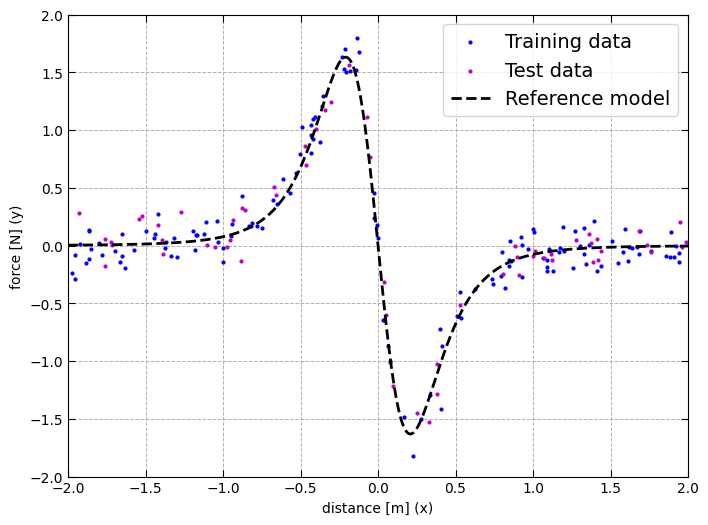

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')
S.split()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)
S_know  = S.knowledge.synth_dataset()

In [3]:
#from backprop import project
#project.project_semantic(S_train.y, S_train, S.knowledge)
#S_train.get_plotter().plot(width=8, height=6)

In [ ]:
lib = library.Library(2000, 2, S_train)

(square(x0) * exp(x0))
Distance: 289.27355436705847
MSE: 597.7084946867968


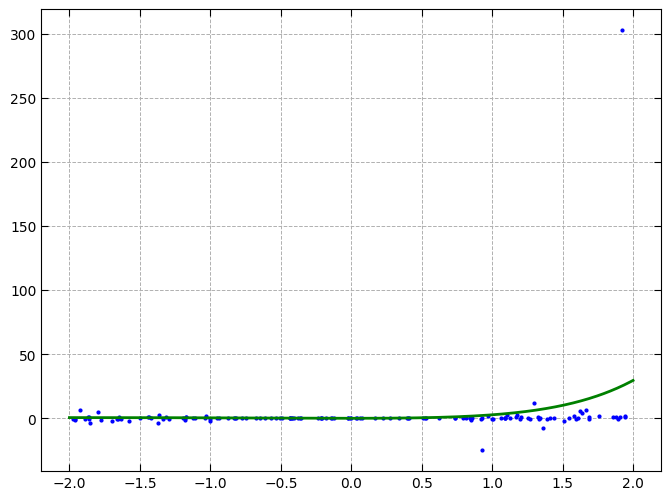

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
True


In [5]:
backprop_node = backprop.ConstantSyntaxTree(2.0)
stree = backprop.BinaryOperatorSyntaxTree('/',
        backprop.BinaryOperatorSyntaxTree('*',
            backprop.ConstantSyntaxTree(-0.05),
            backprop.VariableSyntaxTree(),
        ),
        backprop_node
    )

stree.set_parent()
y = stree(S_train.X)  # needed for 'pull_output'.
pulled_y, _ = backprop_node.pull_output(S_train.y)

S_backprop = dataset.NumpyDataset(S)
S_backprop.X = S_train.X
S_backprop.y = pulled_y

lib_nodes = lib.multiquery(pulled_y, k=200)
lib_node = lib_nodes[0][1]
#lib_node = lib.query(pulled_y)
lib_node_dist = library.compute_distance(lib_node(S_backprop.X), pulled_y)
lib_node_mse  = library.compute_mse     (lib_node(S_backprop.X), pulled_y)
lib_node.clear_output()

print(lib_node)
print(f"Distance: {lib_node_dist}")
print(f"MSE: {lib_node_mse}")
S_backprop.get_plotter().plot(width=8, height=6, model=lib_node)

# backprop knowledge.
print(S_know.y)
stree[(S_know.X, ())]  # needed for 'pull_know'.
k_pulled, noroot_pulled = backprop_node.pull_know(S_know.y)
print(k_pulled)
print(noroot_pulled)

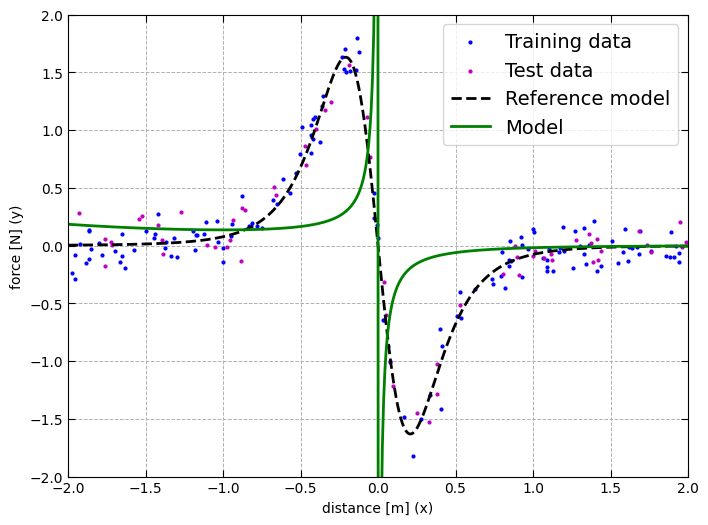

In [6]:
offspring = gp.replace_subtree(stree, backprop_node, lib_node)
#lib_node.parent.invalidate_output()
offspring.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=offspring, zoomout=1)